In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math

# np.random.seed(163)

%run ./DiffusionLunarKF.ipynb
%run ./CentralizedLunarKF.ipynb
%run ./FilterComparison.ipynb

[[0.00656212 0.00087641]
 [0.00087641 0.00015093]]
[[2.44036996e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.53302279e+09 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.44036996e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.53302279e+09]]


In [94]:
C = np.array([[0.5,0.25,0,0.25,0,0,0,0],
                [0.2,0.6,0.2,0,0,0,0,0],
                [0,0.15,0.67,0.18,0,0,0,0],
                [0.2,0,0.2,0.6,0,0,0,0],
                [0.74,0,0,0,0.26,0,0,0],
                [0,0,0,0,0.24,0.4,0.36,0],
                [0,0,0.6,0,0,0,0.3,0.1],
                [0,0,0,0,0.3,0,0.2,0.5]])
# C = np.array([[0.34,0.33,0,0.33,0,0,0,0],
#                 [0.33,0.34,0.33,0,0,0,0,0],
#                 [0,0.33,0.34,0.33,0,0,0,0],
#                 [0.33,0,0.33,0.34,0,0,0,0],
#                 [0.25,0,0,0,0.25,0.25,0,0.25],
#                 [0,0,0,0,0.33,0.34,0.33,0],
#                 [0,0,0.25,0,0,0.25,0.25,0.25],
#                 [0,0,0,0,0.33,0,0.33,0.34]])
D = 3*np.array([[1,1,0,1,1,0,0,0],
                [1,1,1,0,0,0,0,0],
                [0,1,1,1,0,0,1,0],
                [1,0,1,1,0,0,0,0],
                [1,0,0,0,1,1,0,1],
                [0,0,0,0,1,1,1,0],
                [0,0,1,0,0,1,1,1],
                [0,0,0,0,1,0,1,1]])

# C = np.array([[0.5, 0, 0.1, 0.2, 0.2],
#               [0.4, 0.6, 0, 0, 0],
#               [0.1,0,0.9,0,0],
#               [0.1,0,0,0.9,0],
#               [0.1,0,0,0,0.9]])

# D = 3*np.array([[1,1,1,1,1],
#                 [1,1,0,0,0],
#                 [1,0,1,0,0],
#                 [1,0,0,1,0],
#                 [1,0,0,0,1]])



n = len(C)

true_biases = np.array([[np.random.normal(0,np.sqrt(12/(c**2))) for _ in range(n)]]).T
true_drifts = np.array([[np.random.normal(0,np.sqrt(0.1/(c**2))) for _ in range(n)]]).T
# true_drifts = np.array([[0 for _ in range(n)]]).T

F = np.array([[1,dt],[0,1]])
F_full = np.kron(np.eye(n),F)

def get_station_truth(x,id):
    return np.array([[x[2*id][0]],[x[2*id+1][0]]])

x = c*np.vstack(tuple([np.array([true_biases[i],true_drifts[i]]) for i in range(n)]))

# random initial estimates for each node

x0 = [np.array([[np.random.normal(0,np.sqrt(12))],[np.random.normal(0,np.sqrt(0.1))]]) for i in range(n)]
x0_cf = np.vstack(tuple(x0))
# x0 = [np.array([[0],[0]]) for _ in range(n)]

P = [100*np.copy(R(1)) for _ in range(n)]
P_prev = np.block([[P[i] if i==j else np.zeros((2,2)) for j in range(n)] for i in range(n)])

stations = [Station(i) for i in range(n)]

filter_initialize(stations,D,x0,P)

Q_10x10 = np.kron(np.eye(n),Q)

kf = KalmanFilter(A = F_full, H = H_cf, Q = Q_10x10, R = R_cf, P = P_prev, x0 = x0_cf)
#For the first iteration these are our cross_links

In [95]:
iterations = 200
num_msmts = np.array([[3,3,3,3,0,0,0,0] for _ in range(iterations)])
# num_msmts = np.array([np.random.randint(0,6,5) for _ in range(iterations)])
filter_outputs = run_both_filters(iterations, num_msmts,C,F_full,stations,kf, x)

errors_df,errors_cf,P_hist_cf,P_hist_df,truth,measurements,predictions_cf,predictions_df = filter_outputs

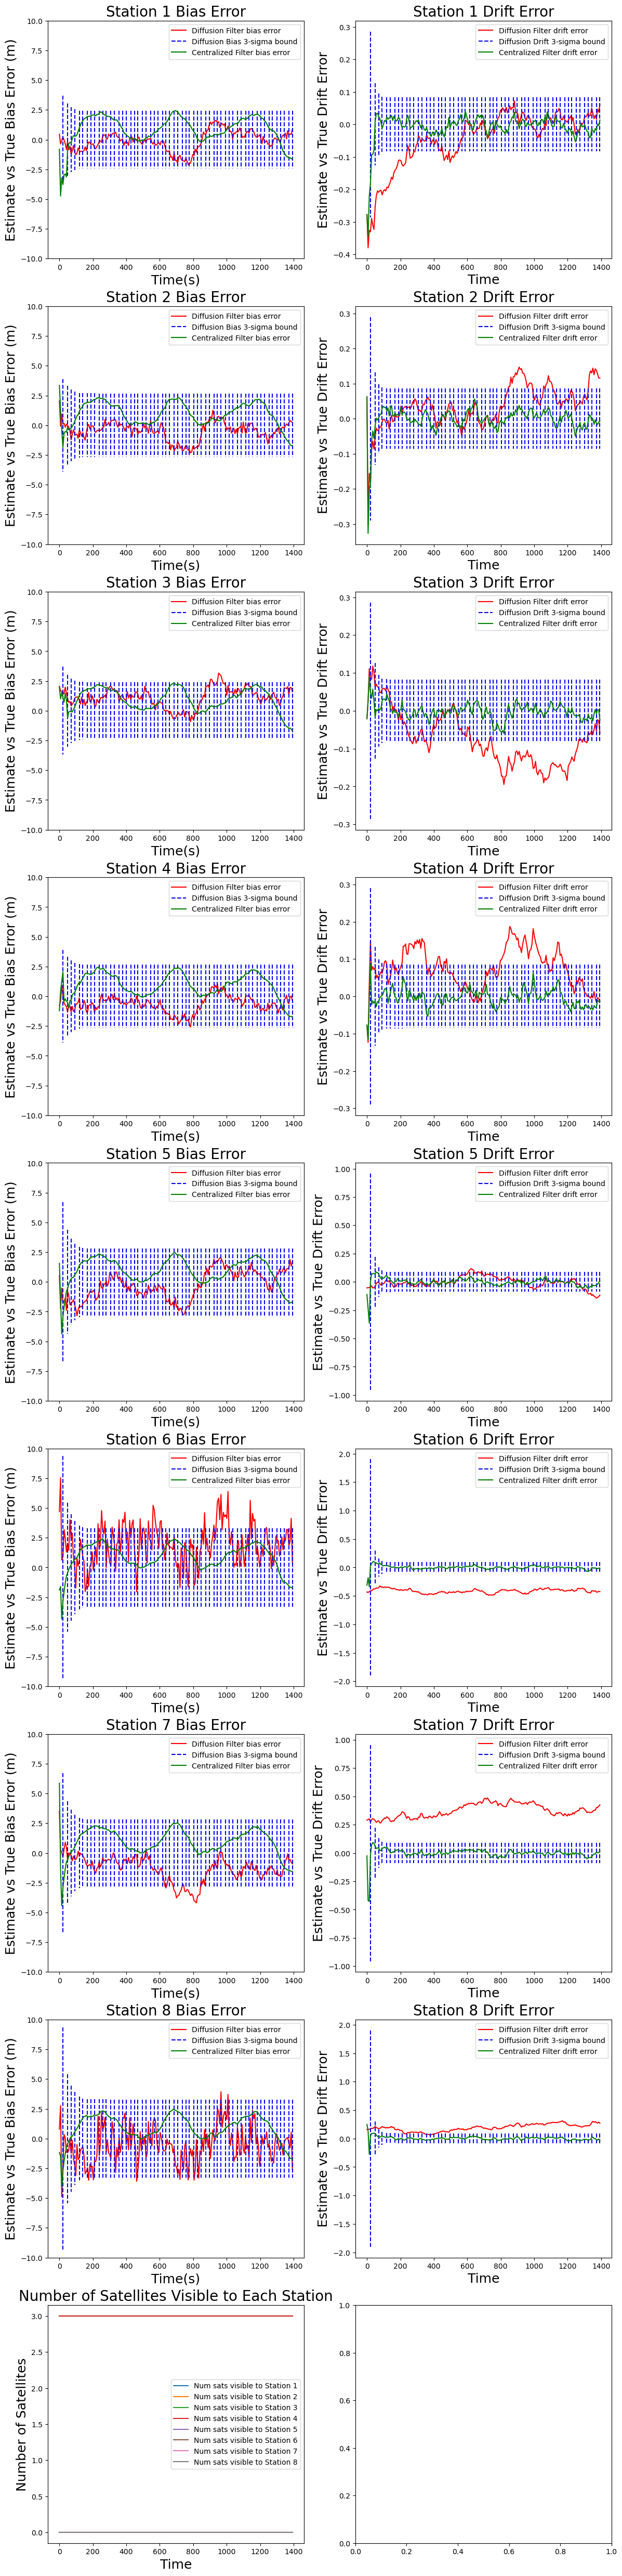

In [96]:
#Number of stations whose plots we are looking at
k = [0,1,2,3,4,5,6,7]

num_rows = len(k)
fig,axs = plt.subplots(num_rows+1,2, figsize=(14, 7*(num_rows+1)))
t_hist_err = np.arange(0, dt*iterations, dt)
t_hist_cf = np.arange(3, dt*iterations, dt)

if iterations > 60:
    t_hist_inx = np.round(np.linspace(0, iterations - 1, 60)).astype(int)
    
    t_hist = t_hist_err[t_hist_inx]
    t_hist_cf = t_hist_cf[t_hist_inx]
else:
    t_hist_inx = [i for i in range(iterations)]
    t_hist = t_hist_err


errors_cf = np.array(errors_cf).squeeze()
P_hist_cf = np.array(P_hist_cf)

for inx,i in enumerate(k):
    #Diffusion Filter Error Plots
    axs[inx][0].plot(t_hist_err, errors_df[:, i,0,0], 'r', label = "Diffusion Filter bias error")
    bias_cov = 3*np.sqrt(P_hist_df[t_hist_inx, i,0,0])
    axs[inx][0].plot(np.vstack([t_hist[1], t_hist[1]]), np.vstack([bias_cov[1], -bias_cov[1]]), 'b--', label = "Diffusion Bias 3-sigma bound")
    axs[inx][0].plot(np.vstack([t_hist[2:], t_hist[2:]]), np.vstack([bias_cov[2:], -bias_cov[2:]]), 'b--')
    error_bias_cf = errors_cf[:, 2*i]
    axs[inx][0].plot(t_hist_err, error_bias_cf, label=f'Centralized Filter bias error',color = "green")
    axs[inx][0].legend()
    axs[inx][0].set_ylim(-10,10)
    axs[inx][0].set_title("Station "+str(i+1)+" Bias Error", fontsize = 20)
    axs[inx][0].set_xlabel("Time(s)", fontsize = 18)
    axs[inx][0].set_ylabel("Estimate vs True Bias Error (m)", fontsize = 18)

    axs[inx][1].plot(t_hist_err, errors_df[:, i,1,0], 'r', label = "Diffusion Filter drift error")
    drift_cov = 3*np.sqrt(P_hist_df[t_hist_inx, i,1,1])
    axs[inx][1].plot(np.vstack([t_hist[1], t_hist[1]]), np.vstack([drift_cov[1], -drift_cov[1]]), 'b--', label = "Diffusion Drift 3-sigma bound")
    axs[inx][1].plot(np.vstack([t_hist[2:], t_hist[2:]]), np.vstack([drift_cov[2:], -drift_cov[2:]]), 'b--')
    error_drift = errors_cf[:, 2*i+1]
    axs[inx][1].plot(t_hist_err, error_drift, label=f'Centralized Filter drift error',color = "green")
    axs[inx][1].legend()
    axs[inx][1].set_title("Station "+str(i+1)+" Drift Error", fontsize = 20)
    axs[inx][1].set_xlabel("Time", fontsize = 18)
    axs[inx][1].set_ylabel("Estimate vs True Drift Error", fontsize = 18)
    
for i in range(n):
    axs[-1][0].plot(t_hist_err,num_msmts[:,i], label = f"Num sats visible to Station {i+1}")
    
axs[-1][0].legend()
axs[-1][0].set_title("Number of Satellites Visible to Each Station", fontsize = 20)
axs[-1][0].set_xlabel("Time", fontsize = 18)
axs[-1][0].set_ylabel("Number of Satellites", fontsize = 18)



plt.savefig("OptimizerPlots/Optimal_MSE_03333.png")